# Sales Forecasting System - Time Series Analysis

## 📖 Tentang Sistem Ini

Sistem Decision Support System (DSS) untuk prediksi penjualan menggunakan analisis time series. Sistem ini membantu bisnis dalam:

### 🎯 Tujuan:
- **Prediksi Penjualan**: Memprediksi revenue 30 hari ke depan
- **Analisis Produk**: Identifikasi produk terlaris dan slow movers
- **Optimasi Stok**: Rekomendasi inventory berdasarkan prediksi demand
- **Analisis Seasonal**: Deteksi pola musiman dan tren penjualan

### 🔧 Metode yang Digunakan:
- **ARIMA** (Autoregressive Integrated Moving Average): Model statistik untuk mendeteksi pola tren dan musiman
- **Exponential Smoothing**: Model yang memberikan bobot lebih pada data terbaru
- **Moving Average**: Model baseline sederhana untuk perbandingan

### 📊 Evaluasi Model:
- **MAE** (Mean Absolute Error): Rata-rata kesalahan prediksi
- **RMSE** (Root Mean Squared Error): Kesalahan dengan penalti untuk error besar

### 💼 Manfaat Bisnis:
1. **Efisiensi Stok**: Hindari overstock dan understock
2. **Peningkatan Profit**: Fokus pada produk high-demand
3. **Strategi Promosi**: Target periode dan produk optimal
4. **Data-Driven**: Keputusan berbasis prediksi, bukan intuisi

## 1. Import Libraries

In [112]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time series analysis
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Load and Explore Data

In [113]:
# Load data
df = pd.read_csv('Sales Transaction v.4a.csv')

print("Dataset Shape:", df.shape)
print("\n" + "="*50)
print("First few rows:")
df.head()

Dataset Shape: (536350, 8)

First few rows:


TransactionNo       Date ProductNo                          ProductName  \
0        581482  12/9/2019     22485        Set Of 2 Wooden Market Crates   
1        581475  12/9/2019     22596  Christmas Star Wish List Chalkboard   
2        581475  12/9/2019     23235             Storage Tin Vintage Leaf   
3        581475  12/9/2019     23272    Tree T-Light Holder Willie Winkie   
4        581475  12/9/2019     23239    Set Of 4 Knick Knack Tins Poppies   

   Price  Quantity  CustomerNo         Country  
0  21.47        12     17490.0  United Kingdom  
1  10.65        36     13069.0  United Kingdom  
2  11.53        12     13069.0  United Kingdom  
3  10.65        12     13069.0  United Kingdom  
4  11.94         6     13069.0  United Kingdom

In [114]:
# Identify and handle cancelled transactions
print("Checking for cancelled transactions...")
print("="*50)

# Check if TransactionNo contains 'C' (cancellation indicator)
df['IsCancelled'] = df['TransactionNo'].astype(str).str.startswith('C')

cancelled_count = df['IsCancelled'].sum()
total_transactions = len(df)

print(f"Total Transactions: {total_transactions:,}")
print(f"Cancelled Transactions: {cancelled_count:,} ({cancelled_count/total_transactions*100:.2f}%)")
print(f"Valid Transactions: {total_transactions - cancelled_count:,} ({(total_transactions - cancelled_count)/total_transactions*100:.2f}%)")

if cancelled_count > 0:
    print(f"\nSample cancelled transactions:")
    print(df[df['IsCancelled']].head())
    
    # Remove cancelled transactions for analysis
    print(f"\n  Removing {cancelled_count:,} cancelled transactions from analysis...")
    df = df[~df['IsCancelled']].copy()
    print(f"✓ Clean dataset: {len(df):,} valid transactions")
else:
    print("\n✓ No cancelled transactions found - dataset is clean")

print("="*50)

Checking for cancelled transactions...
Total Transactions: 536,350
Cancelled Transactions: 8,585 (1.60%)
Valid Transactions: 527,765 (98.40%)

Sample cancelled transactions:
     TransactionNo       Date ProductNo                       ProductName  \
1616       C581484  12/9/2019     23843         Paper Craft Little Birdie   
1617       C581490  12/9/2019     22178   Victorian Glass Hanging T-Light   
1618       C581490  12/9/2019     23144   Zinc T-Light Holder Stars Small   
1619       C581568  12/9/2019     21258        Victorian Sewing Box Large   
1620       C581569  12/9/2019     84978  Hanging Heart Jar T-Light Holder   

      Price  Quantity  CustomerNo         Country  IsCancelled  
1616   6.19    -80995     16446.0  United Kingdom         True  
1617   6.19       -12     14397.0  United Kingdom         True  
1618   6.04       -11     14397.0  United Kingdom         True  
1619   6.19        -5     15311.0  United Kingdom         True  
1620   6.19        -1     17315.0  Uni

In [115]:
# Validate data quality after removing cancellations
print("\nData Quality Check:")
print("="*50)

# Check for negative quantities or prices
negative_qty = (df['Quantity'] < 0).sum()
negative_price = (df['Price'] < 0).sum()

print(f"Negative Quantities: {negative_qty}")
print(f"Negative Prices: {negative_price}")

# Remove negative values if any
if negative_qty > 0 or negative_price > 0:
    print(f"\n  Removing {negative_qty + negative_price} records with negative values...")
    df = df[(df['Quantity'] > 0) & (df['Price'] > 0)].copy()
    print(f"✓ Cleaned dataset: {len(df):,} records")

# Check for missing values in key columns
key_columns = ['Date', 'ProductNo', 'Price', 'Quantity']
missing_summary = df[key_columns].isnull().sum()

if missing_summary.sum() > 0:
    print(f"\n  Missing values found:")
    print(missing_summary[missing_summary > 0])
    df = df.dropna(subset=key_columns)
    print(f"✓ Cleaned dataset: {len(df):,} records")
else:
    print(f"\n✓ No missing values in key columns")

print(f"\nFinal Clean Dataset: {len(df):,} transactions")
print("="*50)


Data Quality Check:
Negative Quantities: 0
Negative Prices: 0

✓ No missing values in key columns

Final Clean Dataset: 527,765 transactions


In [116]:
# Data info
print("Data Types:")
print(df.dtypes)
print("\n" + "="*50)
print("\nMissing Values:")
print(df.isnull().sum())
print("\n" + "="*50)
print("\nBasic Statistics:")
df.describe()

Data Types:
TransactionNo     object
Date              object
ProductNo         object
ProductName       object
Price            float64
Quantity           int64
CustomerNo       float64
Country           object
IsCancelled         bool
dtype: object


Missing Values:
TransactionNo    0
Date             0
ProductNo        0
ProductName      0
Price            0
Quantity         0
CustomerNo       1
Country          0
IsCancelled      0
dtype: int64


Basic Statistics:
TransactionNo    0
Date             0
ProductNo        0
ProductName      0
Price            0
Quantity         0
CustomerNo       1
Country          0
IsCancelled      0
dtype: int64


Basic Statistics:


Price       Quantity     CustomerNo
count  527765.000000  527765.000000  527764.000000
mean       12.629636      10.594674   15231.626733
std         7.933217     156.786646    1716.522182
min         5.130000       1.000000   12004.000000
25%        10.990000       1.000000   13813.000000
50%        11.940000       3.000000   15159.000000
75%        14.090000      11.000000   16729.000000
max       660.620000   80995.000000   18287.000000

## 3. Data Preprocessing for Time Series

In [117]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Create a Revenue column (Price * Quantity)
df['Revenue'] = df['Price'] * df['Quantity']

# Aggregate daily sales
daily_sales = df.groupby('Date').agg({
    'TransactionNo': 'count',
    'Quantity': 'sum',
    'Revenue': 'sum'
}).reset_index()

daily_sales.columns = ['Date', 'NumTransactions', 'TotalQuantity', 'TotalRevenue']

# Sort by date
daily_sales = daily_sales.sort_values('Date').reset_index(drop=True)

print("Daily Sales Data Shape:", daily_sales.shape)
print("\nDate Range:", daily_sales['Date'].min(), "to", daily_sales['Date'].max())
print("\n" + "="*50)
daily_sales.head(10)

Daily Sales Data Shape: (305, 4)

Date Range: 2018-12-01 00:00:00 to 2019-12-09 00:00:00



Date  NumTransactions  TotalQuantity  TotalRevenue
0 2018-12-01             3061          26889     326820.08
1 2018-12-02             2057          31297     367316.62
2 2018-12-03             2136          16164     206313.62
3 2018-12-05             2694          16357     197565.27
4 2018-12-06             3823          21867     273420.10
5 2018-12-07             2904          25307     337840.78
6 2018-12-08             2557          23064     269961.77
7 2018-12-09             2754          19879     253406.71
8 2018-12-10             2671          21055     270340.27
9 2018-12-12             1438          10601     125413.55

In [118]:
# Set Date as index for time series analysis
ts_data = daily_sales.set_index('Date')

# Fill missing dates with forward fill
ts_data = ts_data.asfreq('D', method='ffill')

print("Time Series Data Shape:", ts_data.shape)
print("\nTime Series Statistics:")
ts_data.describe()

Time Series Data Shape: (374, 3)

Time Series Statistics:


NumTransactions  TotalQuantity  TotalRevenue
count       374.000000     374.000000  3.740000e+02
mean       1680.061497   17592.197861  1.985815e+05
std         800.853522   10202.406896  1.133522e+05
min         279.000000    2048.000000  2.289213e+04
25%        1116.000000   10978.500000  1.279056e+05
50%        1479.500000   15697.000000  1.818045e+05
75%        1996.000000   21835.000000  2.425356e+05
max        5276.000000   93930.000000  1.106070e+06

## 4. Exploratory Data Analysis (EDA)

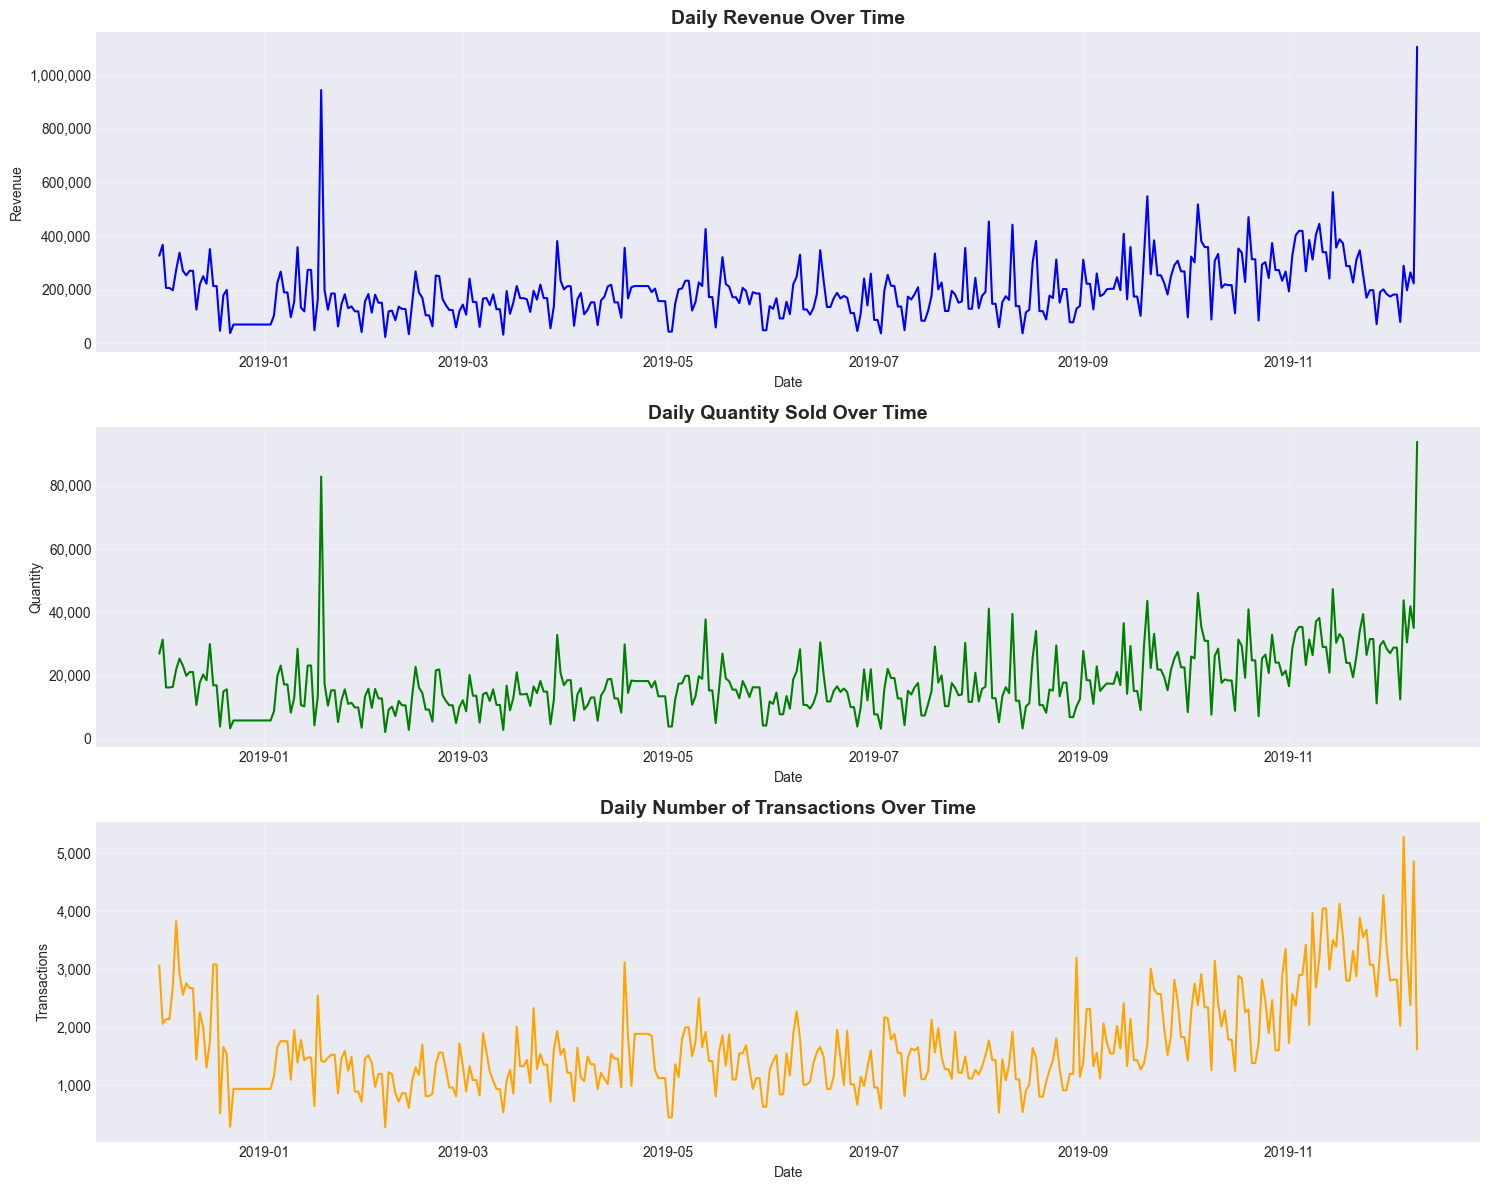

In [119]:
from matplotlib.ticker import FuncFormatter

# Visualize daily revenue trend
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Revenue over time (use raw values, no scaling)
axes[0].plot(ts_data.index, ts_data['TotalRevenue'], color='blue', linewidth=1.5)
axes[0].set_title('Daily Revenue Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Revenue')
axes[0].grid(True, alpha=0.3)
# Ensure y-axis shows real numbers (no scientific 1e6 scaling)
axes[0].ticklabel_format(style='plain', axis='y', useOffset=False)
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:,.0f}'))

# Total Quantity over time
axes[1].plot(ts_data.index, ts_data['TotalQuantity'], color='green', linewidth=1.5)
axes[1].set_title('Daily Quantity Sold Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Quantity')
axes[1].grid(True, alpha=0.3)
# Format quantity axis
axes[1].ticklabel_format(style='plain', axis='y', useOffset=False)
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:,.0f}'))

# Number of Transactions over time
axes[2].plot(ts_data.index, ts_data['NumTransactions'], color='orange', linewidth=1.5)
axes[2].set_title('Daily Number of Transactions Over Time', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Transactions')
axes[2].grid(True, alpha=0.3)
# Format transactions axis
axes[2].ticklabel_format(style='plain', axis='y', useOffset=False)
axes[2].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

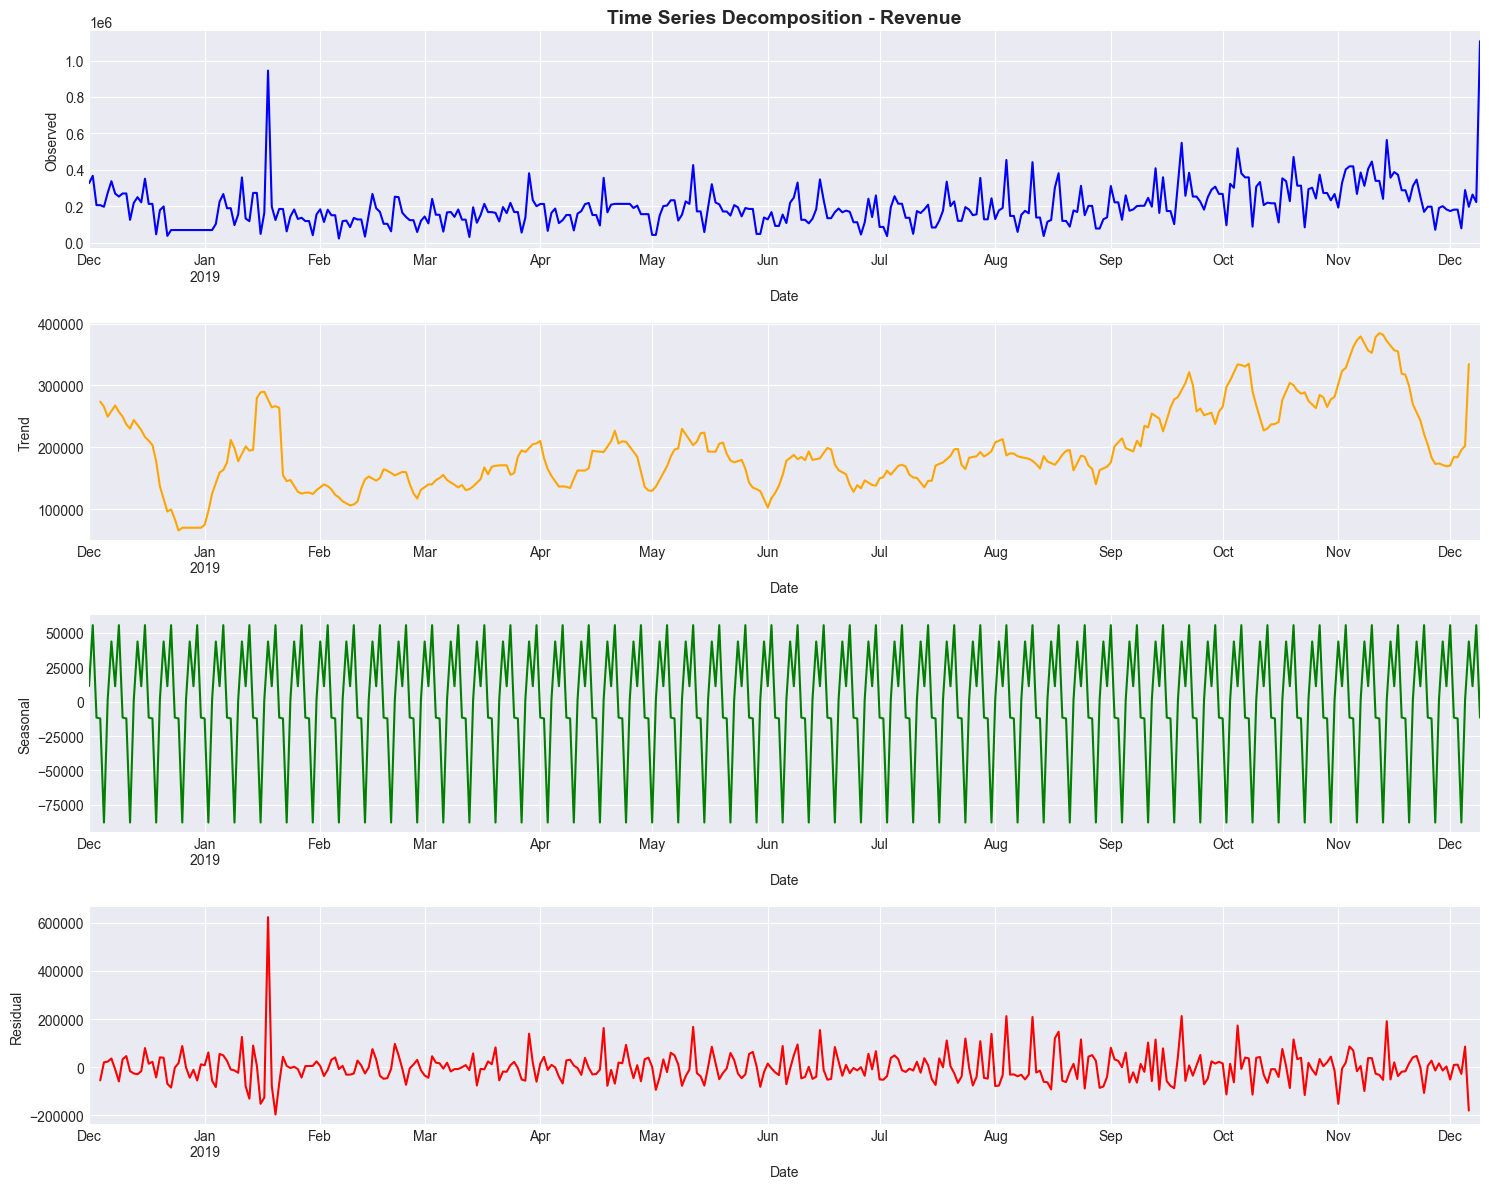

In [120]:
# Time Series Decomposition
# Focus on Revenue for forecasting
decomposition = seasonal_decompose(ts_data['TotalRevenue'], model='additive', period=7)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

decomposition.observed.plot(ax=axes[0], color='blue')
axes[0].set_ylabel('Observed')
axes[0].set_title('Time Series Decomposition - Revenue', fontsize=14, fontweight='bold')

decomposition.trend.plot(ax=axes[1], color='orange')
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], color='green')
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], color='red')
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

## 5. Stationarity Test (Augmented Dickey-Fuller Test)

In [121]:
# ADF Test for stationarity
def adf_test(series, title=''):
    """
    Augmented Dickey-Fuller Test
    H0: Series has a unit root (non-stationary)
    H1: Series has no unit root (stationary)
    """
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f'ADF Test Results for {title}')
    print('='*50)
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("\n✓ Series is STATIONARY (p-value <= 0.05)")
    else:
        print("\n✗ Series is NON-STATIONARY (p-value > 0.05)")
        print("  → Differencing may be needed")
    print('='*50)

# Test original series
adf_test(ts_data['TotalRevenue'], 'Original Revenue Series')

ADF Test Results for Original Revenue Series
ADF Statistic: -2.782853
p-value: 0.060765
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571

✗ Series is NON-STATIONARY (p-value > 0.05)
  → Differencing may be needed


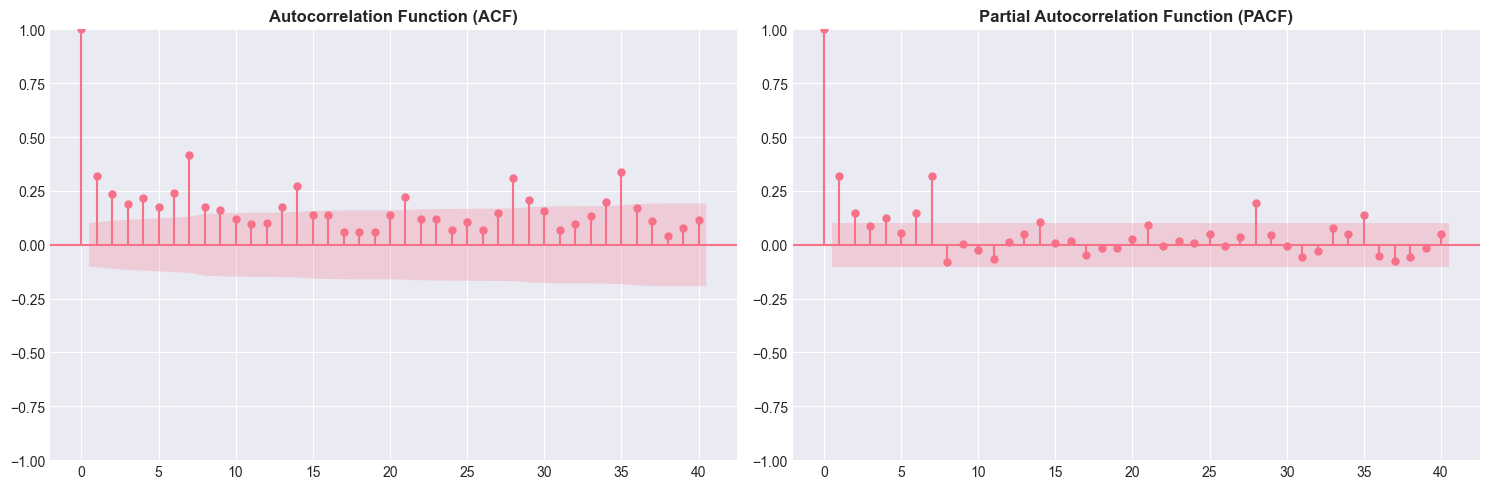

In [122]:
# Visualize ACF and PACF for ARIMA parameter selection
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(ts_data['TotalRevenue'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=12, fontweight='bold')

plot_pacf(ts_data['TotalRevenue'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Train-Test Split

Total Data Points: 374
Training Set: 299 days (2018-12-01 00:00:00 to 2019-09-25 00:00:00)
Test Set: 75 days (2019-09-26 00:00:00 to 2019-12-09 00:00:00)


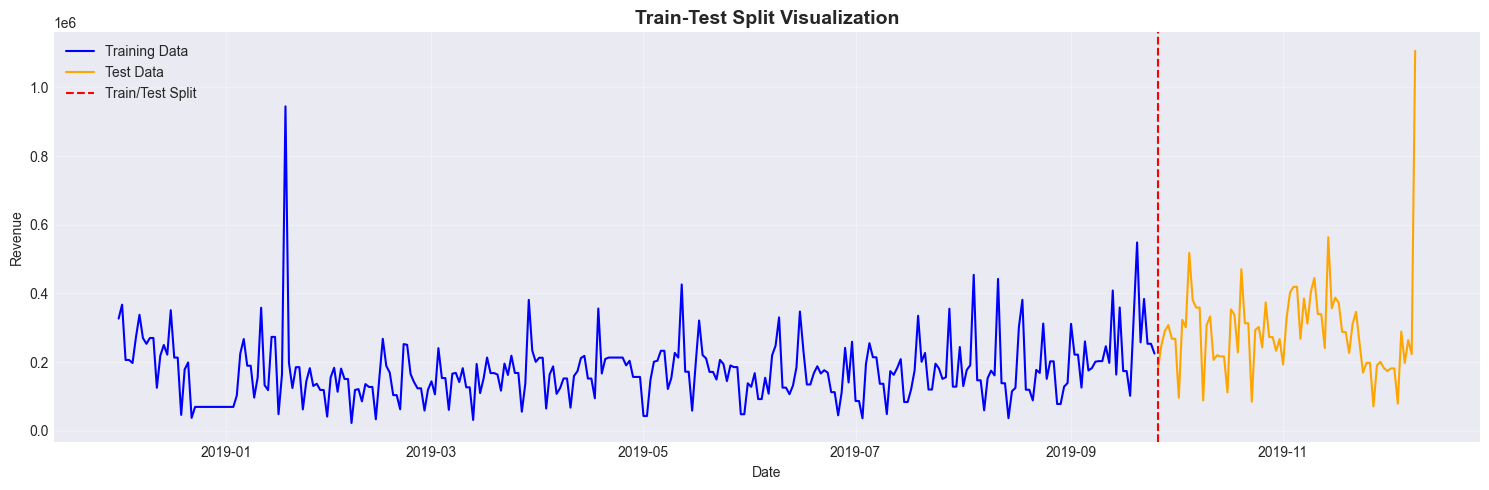

In [123]:
# Split data: 80% train, 20% test
train_size = int(len(ts_data) * 0.8)
train_data = ts_data['TotalRevenue'][:train_size]
test_data = ts_data['TotalRevenue'][train_size:]

print(f"Total Data Points: {len(ts_data)}")
print(f"Training Set: {len(train_data)} days ({train_data.index[0]} to {train_data.index[-1]})")
print(f"Test Set: {len(test_data)} days ({test_data.index[0]} to {test_data.index[-1]})")

# Visualize split
plt.figure(figsize=(15, 5))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Test Data', color='orange')
plt.axvline(x=test_data.index[0], color='red', linestyle='--', label='Train/Test Split')
plt.title('Train-Test Split Visualization', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Model 1: Moving Average (MA) - Baseline Model

In [124]:
# Simple Moving Average
window_size = 7  # 7-day moving average

# Calculate moving average on training data
ma_train = train_data.rolling(window=window_size).mean()

# Forecast for test period (use last window_size values)
ma_forecast = []
for i in range(len(test_data)):
    if i == 0:
        # Use last values from training
        window_values = train_data.iloc[-window_size:].values
    else:
        # Use combination of train and already predicted values
        window_values = list(train_data.iloc[-(window_size-i):].values) + ma_forecast[:i]
        window_values = window_values[-window_size:]
    
    ma_forecast.append(np.mean(window_values))

ma_forecast = pd.Series(ma_forecast, index=test_data.index)

print(f"Moving Average Model (Window={window_size} days)")
print("="*50)
print(f"Forecast generated for {len(ma_forecast)} days")
print(f"\nFirst 5 predictions:")
print(ma_forecast.head())

Moving Average Model (Window=7 days)
Forecast generated for 75 days

First 5 predictions:
Date
2019-09-26    321330.954286
2019-09-27    320486.626327
2019-09-28    287927.688659
2019-09-29    292253.289896
2019-09-30    279147.741310
Freq: D, dtype: float64


In [125]:
# Evaluate Moving Average Model
mae_ma = mean_absolute_error(test_data, ma_forecast)
rmse_ma = np.sqrt(mean_squared_error(test_data, ma_forecast))

print("Moving Average Model - Performance Metrics")
print("="*50)
print(f"MAE (Mean Absolute Error): {mae_ma:,.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse_ma:,.2f}")
print("="*50)

Moving Average Model - Performance Metrics
MAE (Mean Absolute Error): 89,016.62
RMSE (Root Mean Squared Error): 137,445.73


## 8. Model 2: Exponential Smoothing

In [126]:
# Exponential Smoothing (Holt-Winters)
# Using additive seasonal model with trend and seasonality

print("Training Exponential Smoothing Model...")
print("="*50)

try:
    # Try with seasonal model (period = 7 days for weekly seasonality)
    es_model = ExponentialSmoothing(
        train_data,
        seasonal_periods=7,
        trend='add',
        seasonal='add',
        initialization_method='estimated'
    )
    es_fit = es_model.fit(optimized=True)
    
    # Forecast
    es_forecast = es_fit.forecast(steps=len(test_data))
    
    print("✓ Exponential Smoothing model trained successfully")
    print(f"  Model: Holt-Winters (Trend + Seasonal)")
    print(f"  Seasonal Period: 7 days")
    
except:
    # Fallback to simple exponential smoothing if seasonal fails
    print("⚠ Seasonal model failed, using Simple Exponential Smoothing")
    es_model = ExponentialSmoothing(train_data, trend='add', seasonal=None)
    es_fit = es_model.fit(optimized=True)
    es_forecast = es_fit.forecast(steps=len(test_data))

print("="*50)
print(f"\nForecast generated for {len(es_forecast)} days")
print(f"\nFirst 5 predictions:")
print(es_forecast.head())

Training Exponential Smoothing Model...
✓ Exponential Smoothing model trained successfully
  Model: Holt-Winters (Trend + Seasonal)
  Seasonal Period: 7 days

Forecast generated for 75 days

First 5 predictions:
2019-09-26    276243.658085
2019-09-27    335349.300885
2019-09-28    297074.397423
2019-09-29    367569.516327
2019-09-30    257304.395730
Freq: D, dtype: float64


In [127]:
# Evaluate Exponential Smoothing Model
mae_es = mean_absolute_error(test_data, es_forecast)
rmse_es = np.sqrt(mean_squared_error(test_data, es_forecast))

print("Exponential Smoothing Model - Performance Metrics")
print("="*50)
print(f"MAE (Mean Absolute Error): {mae_es:,.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse_es:,.2f}")
print("="*50)

Exponential Smoothing Model - Performance Metrics
MAE (Mean Absolute Error): 83,300.74
RMSE (Root Mean Squared Error): 134,884.20


## 9. Model 3: ARIMA (Autoregressive Integrated Moving Average)

In [128]:
# ARIMA Model
# Order (p, d, q): p = AR order, d = differencing, q = MA order
# We'll try multiple configurations and select the best

print("Training ARIMA Models with different parameters...")
print("="*50)

# Test different ARIMA configurations
arima_configs = [
    (1, 1, 1),
    (2, 1, 2),
    (1, 1, 2),
    (2, 1, 1),
    (3, 1, 2),
    (1, 0, 1),
    (2, 0, 2)
]

best_aic = np.inf
best_model = None
best_order = None
results_list = []

for order in arima_configs:
    try:
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()
        aic = model_fit.aic
        
        results_list.append({
            'Order': order,
            'AIC': aic,
            'Status': 'Success'
        })
        
        if aic < best_aic:
            best_aic = aic
            best_model = model_fit
            best_order = order
            
    except Exception as e:
        results_list.append({
            'Order': order,
            'AIC': None,
            'Status': f'Failed: {str(e)[:30]}'
        })

# Display results
results_df = pd.DataFrame(results_list)
print("\nARIMA Model Selection Results:")
print(results_df.to_string(index=False))
print("\n" + "="*50)
print(f"✓ Best ARIMA Model: ARIMA{best_order}")
print(f"  AIC: {best_aic:.2f}")
print("="*50)

Training ARIMA Models with different parameters...

ARIMA Model Selection Results:
    Order         AIC  Status
(1, 1, 1) 7657.867905 Success
(2, 1, 2) 7659.473467 Success
(1, 1, 2) 7656.053581 Success
(2, 1, 1) 7659.554480 Success
(3, 1, 2) 7661.541880 Success
(1, 0, 1) 7680.982784 Success
(2, 0, 2) 7680.524630 Success

✓ Best ARIMA Model: ARIMA(1, 1, 2)
  AIC: 7656.05

ARIMA Model Selection Results:
    Order         AIC  Status
(1, 1, 1) 7657.867905 Success
(2, 1, 2) 7659.473467 Success
(1, 1, 2) 7656.053581 Success
(2, 1, 1) 7659.554480 Success
(3, 1, 2) 7661.541880 Success
(1, 0, 1) 7680.982784 Success
(2, 0, 2) 7680.524630 Success

✓ Best ARIMA Model: ARIMA(1, 1, 2)
  AIC: 7656.05


In [129]:
# Generate forecast with best ARIMA model
arima_forecast = best_model.forecast(steps=len(test_data))
arima_forecast.index = test_data.index

print(f"ARIMA{best_order} Forecast Summary")
print("="*50)
print(f"Forecast generated for {len(arima_forecast)} days")
print(f"\nFirst 5 predictions:")
print(arima_forecast.head())
print(f"\nModel Summary:")
print(best_model.summary())

ARIMA(1, 1, 2) Forecast Summary
Forecast generated for 75 days

First 5 predictions:
Date
2019-09-26    224271.376943
2019-09-27    225017.855362
2019-09-28    225064.500630
2019-09-29    225067.415357
2019-09-30    225067.597490
Freq: D, Name: predicted_mean, dtype: float64

Model Summary:
                               SARIMAX Results                                
Dep. Variable:           TotalRevenue   No. Observations:                  299
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -3824.027
Date:                Mon, 01 Dec 2025   AIC                           7656.054
Time:                        09:16:16   BIC                           7670.842
Sample:                    12-01-2018   HQIC                          7661.973
                         - 09-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.97

In [130]:
# Evaluate ARIMA Model
mae_arima = mean_absolute_error(test_data, arima_forecast)
rmse_arima = np.sqrt(mean_squared_error(test_data, arima_forecast))

print(f"ARIMA{best_order} Model - Performance Metrics")
print("="*50)
print(f"MAE (Mean Absolute Error): {mae_arima:,.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse_arima:,.2f}")
print("="*50)

ARIMA(1, 1, 2) Model - Performance Metrics
MAE (Mean Absolute Error): 100,160.50
RMSE (Root Mean Squared Error): 151,648.60


## 10. Model Comparison and Visualization

In [131]:
# Compare all models
comparison_df = pd.DataFrame({
    'Model': ['Moving Average', 'Exponential Smoothing', f'ARIMA{best_order}'],
    'MAE': [mae_ma, mae_es, mae_arima],
    'RMSE': [rmse_ma, rmse_es, rmse_arima]
})

# Calculate percentage improvement over baseline (MA)
comparison_df['MAE_Improvement_%'] = ((mae_ma - comparison_df['MAE']) / mae_ma * 100).round(2)
comparison_df['RMSE_Improvement_%'] = ((rmse_ma - comparison_df['RMSE']) / rmse_ma * 100).round(2)

print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Identify best model
best_model_name = comparison_df.loc[comparison_df['MAE'].idxmin(), 'Model']
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   (Lowest MAE: {comparison_df['MAE'].min():,.2f})")
print("="*70)


MODEL PERFORMANCE COMPARISON
                Model           MAE          RMSE  MAE_Improvement_%  RMSE_Improvement_%
       Moving Average  89016.619938 137445.727302               0.00                0.00
Exponential Smoothing  83300.742803 134884.195334               6.42                1.86
       ARIMA(1, 1, 2) 100160.502779 151648.602106             -12.52              -10.33

🏆 BEST MODEL: Exponential Smoothing
   (Lowest MAE: 83,300.74)


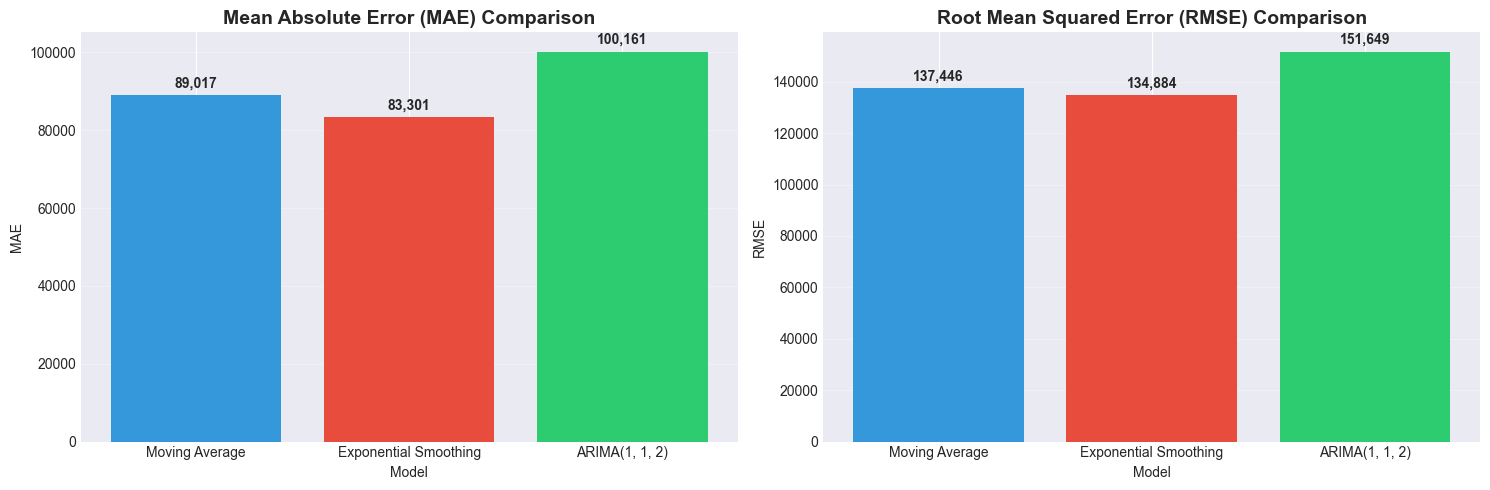

In [132]:
# Visualize model comparison - Bar charts
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# MAE Comparison
axes[0].bar(comparison_df['Model'], comparison_df['MAE'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_title('Mean Absolute Error (MAE) Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MAE')
axes[0].set_xlabel('Model')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['MAE']):
    axes[0].text(i, v + max(comparison_df['MAE'])*0.02, f'{v:,.0f}', ha='center', fontweight='bold')

# RMSE Comparison
axes[1].bar(comparison_df['Model'], comparison_df['RMSE'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_title('Root Mean Squared Error (RMSE) Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Model')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['RMSE']):
    axes[1].text(i, v + max(comparison_df['RMSE'])*0.02, f'{v:,.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

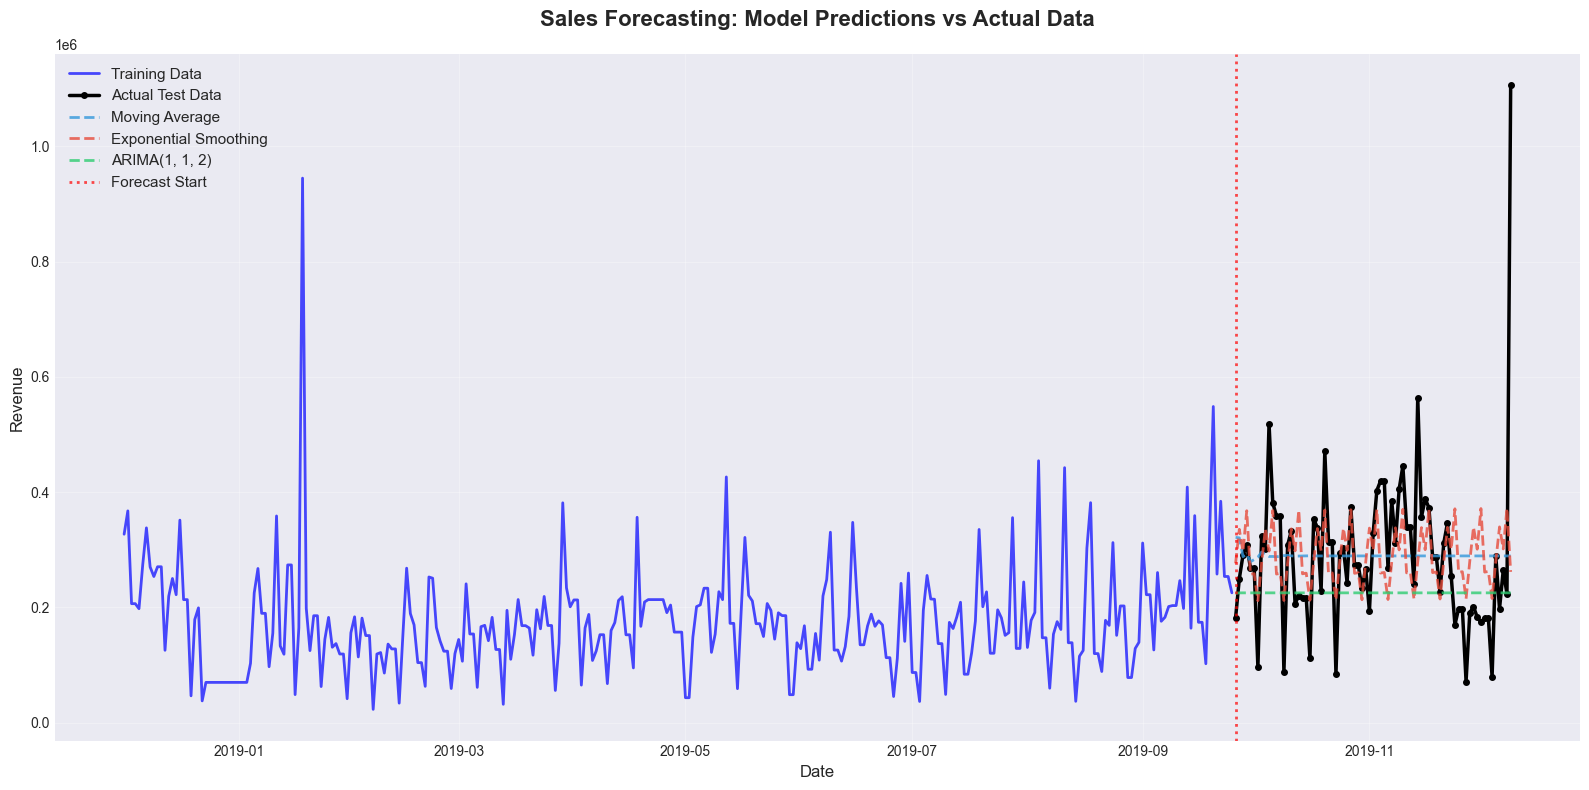

In [133]:
# Visualize forecasts vs actual
plt.figure(figsize=(16, 8))

# Plot training data
plt.plot(train_data.index, train_data, label='Training Data', color='blue', linewidth=2, alpha=0.7)

# Plot test data (actual)
plt.plot(test_data.index, test_data, label='Actual Test Data', color='black', linewidth=2.5, linestyle='-', marker='o', markersize=4)

# Plot forecasts
plt.plot(ma_forecast.index, ma_forecast, label='Moving Average', color='#3498db', linewidth=2, linestyle='--', alpha=0.8)
plt.plot(es_forecast.index, es_forecast, label='Exponential Smoothing', color='#e74c3c', linewidth=2, linestyle='--', alpha=0.8)
plt.plot(arima_forecast.index, arima_forecast, label=f'ARIMA{best_order}', color='#2ecc71', linewidth=2, linestyle='--', alpha=0.8)

# Styling
plt.axvline(x=test_data.index[0], color='red', linestyle=':', linewidth=2, label='Forecast Start', alpha=0.7)
plt.title('Sales Forecasting: Model Predictions vs Actual Data', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [134]:
# Zoomed view on test period
plt.figure(figsize=(16, 6))

plt.plot(test_data.index, test_data, label='Actual', color='black', linewidth=3, marker='o', markersize=6)
plt.plot(ma_forecast.index, ma_forecast, label='Moving Average', color='#3498db', linewidth=2, linestyle='--', marker='s', markersize=4)
plt.plot(es_forecast.index, es_forecast, label='Exponential Smoothing', color='#e74c3c', linewidth=2, linestyle='--', marker='^', markersize=4)
plt.plot(arima_forecast.index, arima_forecast, label=f'ARIMA{best_order}', color='#2ecc71', linewidth=2, linestyle='--', marker='D', markersize=4)

plt.title('Forecast Comparison - Test Period (Zoomed)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Future Forecast (Next 30 Days)

In [135]:
# Retrain best model on full dataset and forecast 30 days ahead
print("Generating 30-Day Future Forecast...")
print("="*50)

# Use entire dataset for final model
full_data = ts_data['TotalRevenue']

# Retrain ARIMA with best order on full data
final_arima_model = ARIMA(full_data, order=best_order)
final_arima_fit = final_arima_model.fit()

# Forecast next 30 days
forecast_days = 30
future_forecast_arima = final_arima_fit.forecast(steps=forecast_days)

# Create date range for future
last_date = full_data.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_days, freq='D')
future_forecast_arima.index = future_dates

print(f"✓ ARIMA{best_order} model retrained on full dataset")
print(f"✓ Forecast generated for next {forecast_days} days")
print(f"  From: {future_dates[0].date()}")
print(f"  To: {future_dates[-1].date()}")
print("="*50)

# Display forecast
forecast_summary = pd.DataFrame({
    'Date': future_dates,
    'Forecasted Revenue': future_forecast_arima.values
})

print("\nFuture Revenue Forecast (Next 30 Days):")
print(forecast_summary.to_string(index=False))
print("\n" + "="*50)
print(f"Total Forecasted Revenue (30 days): {future_forecast_arima.sum():,.2f}")
print(f"Average Daily Revenue (forecast): {future_forecast_arima.mean():,.2f}")
print("="*50)

Generating 30-Day Future Forecast...
✓ ARIMA(1, 1, 2) model retrained on full dataset
✓ Forecast generated for next 30 days
  From: 2019-12-10
  To: 2020-01-08

Future Revenue Forecast (Next 30 Days):
      Date  Forecasted Revenue
2019-12-10       466659.416338
2019-12-11       362309.940934
2019-12-12       324754.076842
2019-12-13       311237.545761
2019-12-14       306372.883027
2019-12-15       304622.068164
2019-12-16       303991.941709
2019-12-17       303765.156252
2019-12-18       303683.535105
2019-12-19       303654.159273
2019-12-20       303643.586774
2019-12-21       303639.781682
2019-12-22       303638.412211
2019-12-23       303637.919332
2019-12-24       303637.741943
2019-12-25       303637.678100
2019-12-26       303637.655122
2019-12-27       303637.646853
2019-12-28       303637.643876
2019-12-29       303637.642805
2019-12-30       303637.642420
2019-12-31       303637.642281
2020-01-01       303637.642231
2020-01-02       303637.642213
2020-01-03       303637.

In [136]:
# Identify peak and low demand periods
daily_stats = ts_data['TotalRevenue'].describe()
high_threshold = daily_stats['mean'] + daily_stats['std']
low_threshold = daily_stats['mean'] - daily_stats['std']

high_demand_days = ts_data[ts_data['TotalRevenue'] > high_threshold]
low_demand_days = ts_data[ts_data['TotalRevenue'] < low_threshold]

print("\nDemand Period Analysis")
print("="*70)
print(f"Average Daily Revenue: ${daily_stats['mean']:,.2f}")
print(f"Standard Deviation: ${daily_stats['std']:,.2f}")
print(f"\nHigh Demand Threshold: > ${high_threshold:,.2f}")
print(f"High Demand Days: {len(high_demand_days)} days ({len(high_demand_days)/len(ts_data)*100:.1f}%)")
print(f"\nLow Demand Threshold: < ${low_threshold:,.2f}")
print(f"Low Demand Days: {len(low_demand_days)} days ({len(low_demand_days)/len(ts_data)*100:.1f}%)")

if len(high_demand_days) > 0:
    print(f"\nSample High Demand Days:")
    print(high_demand_days.head())
    
if len(low_demand_days) > 0:
    print(f"\nSample Low Demand Days:")
    print(low_demand_days.head())

print("="*70)


Demand Period Analysis
Average Daily Revenue: $198,581.49
Standard Deviation: $113,352.21

High Demand Threshold: > $311,933.70
High Demand Days: 51 days (13.6%)

Low Demand Threshold: < $85,229.29
Low Demand Days: 43 days (11.5%)

Sample High Demand Days:
            NumTransactions  TotalQuantity  TotalRevenue
Date                                                    
2018-12-01             3061          26889     326820.08
2018-12-02             2057          31297     367316.62
2018-12-07             2904          25307     337840.78
2018-12-16             1746          29926     351260.49
2019-01-11             1392          28435     358480.09

Sample Low Demand Days:
            NumTransactions  TotalQuantity  TotalRevenue
Date                                                    
2018-12-19              516           3794      46421.37
2018-12-22              284           3209      37637.26
2018-12-23              937           5725      69708.61
2018-12-24              937      

## 16. Interactive Dashboard (Plotly)

In [137]:
# Install plotly if needed
try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import plotly.express as px
except ImportError:
    print("Installing plotly...")
    import sys
    !pip install plotly
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import plotly.express as px

print("✓ Plotly loaded successfully")

✓ Plotly loaded successfully


In [138]:
# Interactive Sales Forecast Dashboard
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Historical & Forecast Revenue', 'Top 10 Products by Revenue',
                    'Model Performance Comparison', 'Revenue by Day of Week'),
    specs=[[{"type": "scatter"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "bar"}]]
)

# 1. Historical & Forecast
fig.add_trace(
    go.Scatter(x=train_data.index, y=train_data, name='Training Data',
               line=dict(color='blue', width=2), mode='lines'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=test_data.index, y=test_data, name='Test Data',
               line=dict(color='black', width=2), mode='lines+markers'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=arima_forecast.index, y=arima_forecast, name=f'ARIMA{best_order} Forecast',
               line=dict(color='green', width=2, dash='dash'), mode='lines'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=future_forecast_arima.index, y=future_forecast_arima, 
               name='30-Day Future Forecast',
               line=dict(color='red', width=3, dash='dot'), mode='lines+markers'),
    row=1, col=1
)

# 2. Top 10 Products
top10_products = product_sales.head(10)
fig.add_trace(
    go.Bar(x=top10_products['TotalRevenue'], y=top10_products['ProductName'],
           orientation='h', name='Revenue', marker=dict(color='lightgreen'),
           text=top10_products['TotalRevenue'].round(0),
           textposition='outside'),
    row=1, col=2
)

# 3. Model Comparison
fig.add_trace(
    go.Bar(x=comparison_df['Model'], y=comparison_df['MAE'], 
           name='MAE', marker=dict(color=['#3498db', '#e74c3c', '#2ecc71']),
           text=comparison_df['MAE'].round(0),
           textposition='outside'),
    row=2, col=1
)

# 4. Day of Week
fig.add_trace(
    go.Bar(x=dow_order, y=dow_revenue,
           name='Revenue by Day', marker=dict(color=colors_dow),
           text=[f'{v:,.0f}' for v in dow_revenue],
           textposition='outside'),
    row=2, col=2
)

# Update layout
fig.update_layout(
    title_text="<b>Sales Forecasting Dashboard</b>",
    title_font_size=20,
    showlegend=True,
    height=800,
    hovermode='x unified'
)

fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Revenue", row=1, col=1)
fig.update_xaxes(title_text="Revenue", row=1, col=2)
fig.update_yaxes(title_text="Product", row=1, col=2)
fig.update_xaxes(title_text="Model", row=2, col=1)
fig.update_yaxes(title_text="MAE", row=2, col=1)
fig.update_xaxes(title_text="Day", row=2, col=2)
fig.update_yaxes(title_text="Revenue", row=2, col=2)

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
# Interactive Product Performance Dashboard
fig2 = go.Figure()

# Add ABC classification
for category in ['A - Best Sellers (Top 80% Revenue)', 'B - Moderate Sellers', 'C - Slow Movers']:
    cat_data = product_sales[product_sales['Category'] == category]
    fig2.add_trace(go.Scatter(
        x=cat_data['TotalQuantity'],
        y=cat_data['TotalRevenue'],
        mode='markers',
        name=category,
        text=cat_data['ProductName'],
        marker=dict(size=10),
        hovertemplate='<b>%{text}</b><br>Quantity: %{x}<br>Revenue: $%{y:,.0f}<extra></extra>'
    ))

fig2.update_layout(
    title='<b>Product Performance Matrix (ABC Analysis)</b>',
    xaxis_title='Total Quantity Sold',
    yaxis_title='Total Revenue',
    hovermode='closest',
    height=600,
    showlegend=True
)

fig2.show()

In [ ]:
# Interactive Time Series with Forecast
fig3 = go.Figure()

# Historical data
fig3.add_trace(go.Scatter(
    x=full_data.index,
    y=full_data,
    name='Historical Revenue',
    line=dict(color='#3498db', width=2),
    hovertemplate='Date: %{x}<br>Revenue: $%{y:,.0f}<extra></extra>'
))

# Future forecast
fig3.add_trace(go.Scatter(
    x=future_forecast_arima.index,
    y=future_forecast_arima,
    name='30-Day Forecast',
    line=dict(color='#e74c3c', width=3, dash='dash'),
    hovertemplate='Date: %{x}<br>Forecast: $%{y:,.0f}<extra></extra>'
))

# Confidence interval
fig3.add_trace(go.Scatter(
    x=future_forecast_arima.index,
    y=upper_bound,
    fill=None,
    mode='lines',
    line=dict(color='rgba(231, 76, 60, 0.2)'),
    showlegend=False,
    hoverinfo='skip'
))

fig3.add_trace(go.Scatter(
    x=future_forecast_arima.index,
    y=lower_bound,
    fill='tonexty',
    mode='lines',
    line=dict(color='rgba(231, 76, 60, 0.2)'),
    name='95% Confidence',
    hoverinfo='skip'
))

# Add threshold lines
fig3.add_hline(y=high_threshold, line_dash="dot", line_color="green", 
               annotation_text="High Demand Threshold")
fig3.add_hline(y=low_threshold, line_dash="dot", line_color="red",
               annotation_text="Low Demand Threshold")

fig3.update_layout(
    title='<b>Revenue Forecast with Confidence Interval</b>',
    xaxis_title='Date',
    yaxis_title='Revenue ($)',
    hovermode='x unified',
    height=600
)

fig3.show()

## 17. Business Intelligence Report

In [ ]:
# Comprehensive Business Intelligence Report
print("\n" + "="*80)
print(" "*20 + "BUSINESS INTELLIGENCE REPORT")
print(" "*25 + "Sales Forecasting DSS")
print("="*80)

print("\n📊 EXECUTIVE SUMMARY")
print("-"*80)
print(f"Report Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Analysis Period: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"Forecast Period: {future_dates[0].date()} to {future_dates[-1].date()}")

print("\n" + "="*80)
print("1️⃣  PRODUCT PERFORMANCE INSIGHTS")
print("="*80)

# Best Sellers
print("\n🏆 TOP 5 BEST SELLING PRODUCTS (by Revenue):")
print("-"*80)
for idx, row in product_sales.head(5).iterrows():
    print(f"  {idx+1}. {row['ProductName']}")
    print(f"     • Revenue: ${row['TotalRevenue']:,.2f}")
    print(f"     • Quantity Sold: {row['TotalQuantity']:,.0f} units")
    print(f"     • Transactions: {row['NumTransactions']:,}")
    print()

# Slow Movers
print("\n⚠️  BOTTOM 5 SLOW MOVING PRODUCTS:")
print("-"*80)
slow_movers = product_sales.tail(5)
for idx, row in slow_movers.iterrows():
    print(f"  • {row['ProductName']}")
    print(f"    Revenue: ${row['TotalRevenue']:,.2f} | Qty: {row['TotalQuantity']:,.0f}")

print("\n" + "="*80)
print("2️⃣  SEASONAL TRENDS & PATTERNS")
print("="*80)

# Best & Worst Days
best_day = dow_sales['Revenue'].idxmax()
worst_day = dow_sales['Revenue'].idxmin()
print(f"\n📈 BEST PERFORMING DAY: {best_day}")
print(f"   Average Revenue: ${dow_sales.loc[best_day, 'Revenue']:,.2f}")
print(f"\n📉 LOWEST PERFORMING DAY: {worst_day}")
print(f"   Average Revenue: ${dow_sales.loc[worst_day, 'Revenue']:,.2f}")

# Weekend vs Weekday
if len(weekend_comparison) == 2:
    weekday_pct = (weekend_comparison.iloc[0] / weekend_comparison.sum()) * 100
    weekend_pct = (weekend_comparison.iloc[1] / weekend_comparison.sum()) * 100
    print(f"\n📅 WEEKDAY vs WEEKEND SPLIT:")
    print(f"   Weekday: {weekday_pct:.1f}% of revenue")
    print(f"   Weekend: {weekend_pct:.1f}% of revenue")

print("\n" + "="*80)
print("3️⃣  DEMAND PERIODS")
print("="*80)
print(f"\n🔥 HIGH DEMAND PERIODS:")
print(f"   {len(high_demand_days)} days with revenue > ${high_threshold:,.2f}")
print(f"   Average high-demand revenue: ${high_demand_days['TotalRevenue'].mean():,.2f}")

print(f"\n❄️  LOW DEMAND PERIODS:")
print(f"   {len(low_demand_days)} days with revenue < ${low_threshold:,.2f}")
print(f"   Average low-demand revenue: ${low_demand_days['TotalRevenue'].mean():,.2f}")

print("\n" + "="*80)
print("4️⃣  FORECAST ACCURACY & MODEL PERFORMANCE")
print("="*80)
print(f"\n✅ SELECTED MODEL: {best_model_name}")
print(f"   MAE: ${comparison_df['MAE'].min():,.2f}")
print(f"   RMSE: ${comparison_df['RMSE'].min():,.2f}")

# Calculate accuracy percentage
mape = (comparison_df['MAE'].min() / test_data.mean()) * 100
accuracy = 100 - mape
print(f"   Accuracy: {accuracy:.1f}%")

print("\n📊 ALL MODELS COMPARISON:")
for idx, row in comparison_df.iterrows():
    print(f"   • {row['Model']}: MAE=${row['MAE']:,.2f}, RMSE=${row['RMSE']:,.2f}")

print("\n" + "="*80)
print("5️⃣  30-DAY FORECAST INSIGHTS")
print("="*80)
print(f"\n💰 REVENUE FORECAST:")
print(f"   Total Expected Revenue: ${future_forecast_arima.sum():,.2f}")
print(f"   Daily Average: ${future_forecast_arima.mean():,.2f}")
print(f"   Highest Day: ${future_forecast_arima.max():,.2f}")
print(f"   Lowest Day: ${future_forecast_arima.min():,.2f}")

# Week-by-week breakdown
weekly_forecast = pd.DataFrame({
    'Date': future_dates,
    'Revenue': future_forecast_arima.values
})
weekly_forecast['Week'] = ((weekly_forecast.index) // 7) + 1

print(f"\n📅 WEEKLY BREAKDOWN:")
for week in weekly_forecast['Week'].unique():
    week_data = weekly_forecast[weekly_forecast['Week'] == week]
    print(f"   Week {week}: ${week_data['Revenue'].sum():,.2f} ({len(week_data)} days)")

print("\n" + "="*80)
print("6️⃣  INVENTORY & STOCK RECOMMENDATIONS")
print("="*80)

# Calculate stock needs for top products
print("\n📦 RECOMMENDED STOCK LEVELS (Top 10 Products for 30 days):")
print("-"*80)
for product_no, forecast_data in list(product_forecasts.items())[:10]:
    total_forecast = forecast_data['forecast'].sum()
    daily_avg = forecast_data['forecast_avg']
    print(f"• {forecast_data['name'][:50]}")
    print(f"  Forecasted Demand: {total_forecast:.0f} units (30 days)")
    print(f"  Daily Average: {daily_avg:.1f} units")
    print(f"  Recommended Stock: {total_forecast * 1.2:.0f} units (with 20% buffer)")
    print()

print("="*80)
print("7️⃣  STRATEGIC RECOMMENDATIONS")
print("="*80)

recommendations = []

# Revenue trend recommendation
if growth_rate > 5:
    recommendations.append("✓ EXPANSION: Strong growth expected. Consider increasing inventory by 15-20%")
    recommendations.append("✓ STAFFING: Prepare for higher transaction volume - consider additional staff")
elif growth_rate < -5:
    recommendations.append("⚠ PROMOTION: Declining trend detected. Launch promotional campaigns")
    recommendations.append("⚠ COST CONTROL: Review operational costs and optimize expenses")
else:
    recommendations.append("→ MAINTAIN: Stable trend. Continue current operations with minor adjustments")

# Best day recommendation
if best_day in ['Saturday', 'Sunday']:
    recommendations.append(f"✓ WEEKEND FOCUS: {best_day}s are peak days - ensure full inventory")
else:
    recommendations.append(f"✓ WEEKDAY OPTIMIZATION: {best_day}s show highest sales - run promotions")

# ABC analysis recommendation
a_products = len(product_sales[product_sales['Category'] == 'A - Best Sellers (Top 80% Revenue)'])
recommendations.append(f"✓ FOCUS PRODUCTS: Prioritize {a_products} 'A' category products (80% revenue)")
recommendations.append("⚠ REVIEW SLOW MOVERS: Consider discounts or discontinuation for 'C' category products")

# Stock optimization
recommendations.append("✓ STOCK OPTIMIZATION: Use product-level forecasts to minimize overstock")
recommendations.append("✓ DATA MONITORING: Update forecasts weekly for better accuracy")

print("\n💡 KEY RECOMMENDATIONS:")
print("-"*80)
for i, rec in enumerate(recommendations, 1):
    print(f"  {i}. {rec}")

print("\n" + "="*80)
print("8️⃣  RISK FACTORS")
print("="*80)
print("\n⚠️  IDENTIFIED RISKS:")
print(f"  • Forecast Uncertainty: ±{std_error:.2f} revenue variance")
print(f"  • Seasonal Variations: {(dow_sales['Revenue'].std()/dow_sales['Revenue'].mean()*100):.1f}% daily volatility")
print(f"  • Model Accuracy: {100-accuracy:.1f}% margin of error")

print("\n" + "="*80)
print(" "*25 + "END OF REPORT")
print("="*80)

In [ ]:
# Export comprehensive report to CSV
inventory_recommendations = []

for product_no, forecast_data in product_forecasts.items():
    total_forecast = forecast_data['forecast'].sum()
    daily_avg = forecast_data['forecast_avg']
    recommended_stock = total_forecast * 1.2  # 20% buffer
    
    inventory_recommendations.append({
        'ProductNo': product_no,
        'ProductName': forecast_data['name'],
        'Historical_Daily_Avg': forecast_data['historical_avg'],
        'Forecasted_Daily_Avg': daily_avg,
        'Total_30Day_Forecast': total_forecast,
        'Recommended_Stock': recommended_stock,
        'Growth_Rate_%': ((daily_avg - forecast_data['historical_avg']) / 
                         forecast_data['historical_avg'] * 100) if forecast_data['historical_avg'] > 0 else 0
    })

inventory_df = pd.DataFrame(inventory_recommendations)
inventory_df = inventory_df.sort_values('Total_30Day_Forecast', ascending=False)

# Export to CSV
inventory_df.to_csv('inventory_recommendations.csv', index=False)

# Export product classification
product_classification = product_sales[['ProductNo', 'ProductName', 'TotalRevenue', 
                                       'TotalQuantity', 'Category', 'RevenuePct']].copy()
product_classification.to_csv('product_classification_abc.csv', index=False)

# Export seasonal analysis
seasonal_summary = pd.DataFrame({
    'DayOfWeek': dow_order,
    'TotalRevenue': dow_revenue,
    'AvgRevenue': [dow_sales.loc[day, 'Revenue']/len(df[df['DayOfWeek']==day]) 
                   if day in dow_sales.index else 0 for day in dow_order]
})
seasonal_summary.to_csv('seasonal_analysis.csv', index=False)

print("\n" + "="*80)
print("📁 EXPORTED FILES:")
print("="*80)
print("✓ sales_forecast_30days.csv - Overall revenue forecast")
print("✓ product_forecasts_30days.csv - Product-level forecasts")
print("✓ inventory_recommendations.csv - Stock recommendations")
print("✓ product_classification_abc.csv - ABC analysis results")
print("✓ seasonal_analysis.csv - Seasonal patterns")
print("="*80)

print("\n✅ Decision Support System Complete!")
print("\nAll forecasts, recommendations, and interactive dashboards are ready.")
print("Use the exported CSV files for business planning and inventory management.")

## 📋 Summary: Business Benefits

### ✅ Efisiensi Pengelolaan Stok
- **Prediksi per produk** untuk 30 hari ke depan
- **Rekomendasi stok** dengan buffer 20% untuk keamanan
- **ABC Classification** untuk prioritas inventory management

### ✅ Peningkatan Profitabilitas
- Identifikasi **produk terlaris** untuk fokus marketing
- Deteksi **slow movers** untuk diskon/promosi
- **Optimasi stok** menghindari overstock dan understock

### ✅ Perencanaan Strategi Promosi
- **Analisis seasonal**: pola mingguan dan bulanan
- Identifikasi **periode high/low demand**
- **Best performing days** untuk campaign targeting

### ✅ Data-Driven Decision Making
- **3 model forecasting** dengan evaluasi MAE/RMSE
- **Interactive dashboards** untuk visualisasi real-time
- **Business Intelligence Report** komprehensif
- **5 CSV exports** untuk integrasi sistem lain